# Federated Semantic Segmentation for Self Driving Cars

## STEP 0: SETUP PHASE

### Installs

In [2]:
!pip install torchmetrics
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Mounting Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/MyDrive/AMLproject/

/content/drive/MyDrive/AMLproject


### Imports

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torch_data
import numpy as np
import matplotlib.pyplot as plt
import random
# import torchvision
# import logging
import warnings
import math
import json
import wandb

# from torchvision import transforms
from torch.backends import cudnn
from torch import from_numpy
# from PIL import Image
from torch.utils.data import DataLoader
from torchvision.io import read_image # importare solo se si usa nella classe Dataset
from torchmetrics.classification import MulticlassJaccardIndex

from drive.MyDrive.AMLproject import transform as T


warnings.resetwarnings()
warnings.simplefilter('ignore')

### Cloning FedDrive

In [6]:
if not os.path.isdir('./FedDrive'):
  !git clone https://github.com/Erosinho13/FedDrive

from FedDrive.src.modules.bisenetv2 import BiSeNetV2

### Parameter Configuration Step 2

In [10]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

PARTITION = 'A' # A or B to choose which dataloader to use
SEED = 42
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 19
if NUM_CLASSES == 19:
  cl19 = True

BATCH_SIZE = 8     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing ***
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.05           # The initial Learning Rate ***
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD ***
WEIGHT_DECAY =0.0005  # Regularization, you can keep this at the default ***

NUM_EPOCHS = 10     # Total number of training epochs (iterations over dataset)

# servono per decrementare il lerning rate nel tempo 
# STEP_SIZE = 500       # How many epochs before decreasing learning rate (if using a step-down policy)
# GAMMA = 0.8          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 20
LOG_FREQUENCY_EPOCH = 3

ROOT_DIR = os.path.join('data', 'Cityscapes')
ROOT_DIR_GTA5 = os.path.join('data', 'GTA5')


### Parameter configuration Step 3

In [22]:
PARTITION = "A"  # 'A' or 'B'
SPLIT = 1  # 1 or 2 // 1 = Uniform : 2 = Heterogenous
MAX_SAMPLE_PER_CLIENT = 20

IMAGES_FINAL = "leftImg8bit"
TARGET_FINAL = "gtFine_labelIds"

N_ROUND = 50
CLIENT_PER_ROUND = 5  # clients picked each round
NUM_EPOCHS = 2


CHECKPOINTS = 5


if PARTITION == 'A':
  if SPLIT == 1:
    TOT_CLIENTS = 36
  else:
    TOT_CLIENTS = 46
else:
  if SPLIT == 1:
    TOT_CLIENTS = 25
  else:
    TOT_CLIENTS = 33


### Parameter configuration Step 4

In [36]:
SEED = 42
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 19
if NUM_CLASSES == 19:
  cl19 = True

BATCH_SIZE = 8     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing ***
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.05           # The initial Learning Rate ***
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD ***
WEIGHT_DECAY =0.0005  # Regularization, you can keep this at the default ***

NUM_EPOCHS = 10     # Total number of training epochs (iterations over dataset)

LOG_FREQUENCY = 20
LOG_FREQUENCY_EPOCH = 3

PARTITION = "A"  # 'A' or 'B'
SPLIT = 1  # 1 or 2 // 1 = Uniform : 2 = Heterogenous
# TODO: change UNIFORM with SPLIT
UNIFORM = True
MAX_SAMPLE_PER_CLIENT = 20


N_STYLE = 5
FDA = False

# Checkpoint and best model
use_checkpoint = True 
CKPT_DIR = 'checkpoints'

if FDA:
  best_ckpt_path = f"best_model_FDA_step4.tar"
  ckpt_path = f"model_FDA_step4.tar"
else:
  best_ckpt_path = f"best_model_NOFDA_step4.tar"
  ckpt_path = f"model_NOFDA_step4.tar"

ROOT_DIR = os.path.join('data', 'Cityscapes')
ROOT_DIR_GTA5 = os.path.join('data', 'GTA5')


if PARTITION == 'A':
  if SPLIT == 1:
    TOT_CLIENTS = 36
  else:
    TOT_CLIENTS = 46
else:
  if SPLIT == 1:
    TOT_CLIENTS = 25
  else:
    TOT_CLIENTS = 33

### Data Augmentation Options

In [7]:
# data augmentation options
# set as None if a transformation should not be used

#RANDOM_HORIZONTAL_FLIP = 0.5
RANDOM_HORIZONTAL_FLIP = None      #probability of the image being flipped
#COLOR_JITTER = (0.2,0.3,0.2,0.2) # (brighteness, contrast, saturation, hue)
COLOR_JITTER = None
#RANDOM_ROTATION = 5              # degree of rotation
RANDOM_ROTATION = None
#RANDOM_CROP = (512,1024)         # output size of the crop
RANDOM_CROP = None
RESIZE = (512,1024)              # output size
#RESIZE = None
#RANDOM_VERTICAL_FLIP  = 0.3     # probability of the image being flipped
RANDOM_VERTICAL_FLIP = None
CENTRAL_CROP = None
#CENTRAL_CROP = (512,1024)
#RANDOM_RESIZE_CROP = (1024,2048)
RANDOM_RESIZE_CROP = None

### Transforms setup

In [8]:
def setup_transform():
    transformers = []
    if RANDOM_HORIZONTAL_FLIP is not None:
        transformers.append(T.RandomHorizontalFlip(RANDOM_HORIZONTAL_FLIP))
    if COLOR_JITTER is not None:
        transformers.append(T.ColorJitter(*COLOR_JITTER))
    if RANDOM_ROTATION is not None:
        transformers.append(T.RandomRotation(RANDOM_ROTATION))
    if RANDOM_CROP is not None:
        transformers.append(T.RandomCrop(RANDOM_CROP))
    if RANDOM_VERTICAL_FLIP is not None:
        transformers.append(T.RandomVerticalFlip(RANDOM_VERTICAL_FLIP))
    if CENTRAL_CROP is not None:
        transformers.append(T.CenterCrop(CENTRAL_CROP))
    if RANDOM_RESIZE_CROP is not None:
        transformers.append(T.RandomResizedCrop(RANDOM_RESIZE_CROP))
    if RESIZE is not None:
        transformers.append(T.Resize(RESIZE))

    transformers.append(T.ToTensor())

    transforms = T.Compose(transformers)

    return transforms

### Datsets

In [9]:
class Cityscapes(torch_data.Dataset):

    """
    image path: data/Cityscapes/images/name_leftImg8bit.png
    taget path: data/Cityscapes/labels/name_gtFine_labelIds.png
    """

    def __init__(self, root, transform=None, cl19=False, filename=None, id_client=None):
        eval_classes = [
            7,
            8,
            11,
            12,
            13,
            17,
            19,
            20,
            21,
            22,
            23,
            24,
            25,
            26,
            27,
            28,
            31,
            32,
            33,
        ]
        self.root = root

        if filename is None:
            raise ValueError("filename is None")

        if id_client is not None:
            with open(os.path.join(root, filename)) as f:
                dict_data = json.load(f)

            self.paths_images = [l[0] for l in dict_data[str(id_client)]]
            self.paths_tagets = [l[1] for l in dict_data[str(id_client)]]

        else:
            with open(os.path.join(root, filename), "r") as f:
                lines = f.readlines()

            # manipulate each file row in order to obtain the correct path
            self.paths_images = [l.strip().split("@")[0] for l in lines]
            self.paths_tagets = [l.strip().split("@")[1] for l in lines]

            # self.len = len(self.paths_images)
            # self.transform = transform

        self.len = len(self.paths_images)
        self.transform = transform
        self.return_unprocessed_image = False

        if cl19:
            classes = eval_classes
            mapping = np.zeros((256,), dtype=np.int64) + 255
            for i, cl in enumerate(classes):
                mapping[cl] = i
            self.target_transform = lambda x: from_numpy(mapping[x])

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is the label of segmentation.
        """

        # # using read_image
        # img = read_image(os.path.join(self.root, "images", self.paths_images[index]))
        # target = read_image(os.path.join(self.root, "labels", self.paths_tagets[index]))

        # # using PIL
        img = Image.open(os.path.join(self.root,"images",self.paths_images[index]))
        target = Image.open(os.path.join(self.root,"labels",self.paths_tagets[index]))

        if self.return_unprocessed_image:
            # transform_PIL = T.ToPILImage()
            # img = transform_PIL(img)
            return img

        if self.transform:
            img, target = self.transform(img, target)

        if self.target_transform:
            target = self.target_transform(target)

        return img, target  # output: Tensor[image_channels, image_height, image_width]

        # # using Image.open + np.array
        

        # return np.array(img), np.array(target) # output: Tensor[image_height, image_width, image_channels]

    def __len__(self):
        return self.len


### Validation Utilities

In [14]:

colors = [
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32]    
        ]

label_colours = dict(zip(range(NUM_CLASSES), colors))

def decode_segmap(temp):
    #convert gray scale to color
    #print colored map
    temp=temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, NUM_CLASSES):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

def compute_moiu(net, val_dataloader):
    net = net.to(DEVICE)
    net.train(False)  # Set Network to evaluation mode
    jaccard = MulticlassJaccardIndex(num_classes=NUM_CLASSES, ignore_index=255).to(
        DEVICE
    )

    jacc = 0
    count = 0
    for images, labels in val_dataloader:
        images = images.to(DEVICE, dtype=torch.float32)
        labels = labels.to(DEVICE, dtype=torch.long)
        # Forward Pass
        outputs = net(images)
        # Get predictions
        _, preds = torch.max(outputs.data, 1)

        # Update Corrects
        jacc += jaccard(preds, labels.squeeze())
        count += 1

    # Calculate Accuracy
    metric = jacc.item() / count
    # net.train(True)
    return metric


def validation_plot(net, val_dataloader, n_image):
    net = net.to(DEVICE)
    net.train(False)
    rows = 1
    columns = 3
    for b, (imgs, targets) in enumerate(val_dataloader):
        if b == n_image:
            break
        # i = random.randint(BATCH_SIZE)
        imgsfloat = imgs.to(DEVICE, dtype=torch.float32)
        outputs = net(imgsfloat)
        _, preds = torch.max(outputs.data, 1)
        # Added in order to use the decode_segmap function
        preds = preds.cpu()  # or equally preds = preds.to('cpu')

        # pick the first image of each batch
        print(imgs[0].shape, targets[0].shape)
        print("img:", imgs[0].squeeze().shape, " target:", targets[0].squeeze().shape)
        print("pred:", preds.shape)

        figure = plt.figure(figsize=(10, 20))
        figure.add_subplot(rows, columns, 1)
        #plt.imshow(imgs[0].permute((1, 2, 0)).squeeze())
        plt.imshow(imgs[0].permute((1, 2, 0)).squeeze())
        plt.axis("off")
        plt.title("Image")

        figure.add_subplot(rows, columns, 2)
        #plt.imshow(decode_segmap(targets[0].permute((1, 2, 0)).squeeze()))
        plt.imshow(decode_segmap(targets[0]))
        plt.axis("off")
        plt.title("Groundtruth")

        figure.add_subplot(rows, columns, 3)
        #plt.imshow(decode_segmap(preds[0].squeeze()))
        plt.imshow(decode_segmap(preds[0]))
        plt.axis("off")
        plt.title("Prediction")
        plt.show()
    return

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/MyDrive/AMLproject/

In [ ]:
if not os.path.isdir('./FedDrive'):
  !git clone https://github.com/Erosinho13/FedDrive

from FedDrive.src.modules.bisenetv2 import BiSeNetV2

## STEP 1 : GENERATING DATASETS

### Generate splits for step 2

In [12]:

IMAGES_FINAL = "leftImg8bit"
TARGET_FINAL = "gtFine_labelIds"

with open(os.path.join(ROOT_DIR, "train.txt"), "r") as ft:
    lines_train = ft.readlines()
with open(os.path.join(ROOT_DIR, "val.txt"), "r") as fv:
    lines_val = fv.readlines()

lines = lines_train + lines_val
images = [
    (
        l.split("/")[0],
        l.strip().split("/")[1],
        l.strip().split("/")[1].replace(IMAGES_FINAL, TARGET_FINAL),
    )
    for l in lines
]

with open(os.path.join(ROOT_DIR, "train_B.txt"), "w") as f:
    for l in lines_train:
        img = l.strip().split("/")[1]
        lbl = img.replace(IMAGES_FINAL, TARGET_FINAL)
        f.write(img + "@" + lbl + "\n")

with open(os.path.join(ROOT_DIR, "test_B.txt"), "w") as f:
    for l in lines_val:
        img = l.strip().split("/")[1]
        lbl = img.replace(IMAGES_FINAL, TARGET_FINAL)
        f.write(img + "@" + lbl + "\n")

city_dic = {}

for i in images:
    if i[0] not in city_dic:
        city_dic[i[0]] = []
        city_dic[i[0]].append(tuple(i[1:]))
    else:
        city_dic[i[0]].append(tuple(i[1:]))
test_img = []
train_img = []

for c in city_dic.values():
    s = random.sample(c, 2)
    test_img += s
    train_img += c
    for img in s:
        train_img.remove(img)

# save the split
with open(os.path.join(ROOT_DIR, "test_A.txt"), "w") as f:
    for img in test_img:
        f.write(img[0] + "@" + img[1] + "\n")

with open(os.path.join(ROOT_DIR, "train_A.txt"), "w") as f:
    for img in train_img:
        f.write(str(img[0]) + "@" + img[1] + "\n")


### generating splits for step 3

In [21]:
if PARTITION == "A":
    # train A
    with open(os.path.join(ROOT_DIR, "train_A.txt"), "r") as f:
        lines = f.readlines()
        images = [
            (
                l.strip().split("@")[0],
                l.strip().split("@")[1],
            )
            for l in lines
        ]
if PARTITION == "B":
    # train B
    with open(os.path.join(ROOT_DIR, "train.txt"), "r") as f:
        lines = f.readlines()
        images = [
            (
                l.strip().split("/")[1],
                l.strip().split("/")[1].replace(IMAGES_FINAL, TARGET_FINAL),
            )
            for l in lines
        ]

city_dic = {}
for i in images:
    city_name = i[0].split("_")[0]
    if city_name not in city_dic:
        city_dic[city_name] = []
    city_dic[city_name].append(i)

if SPLIT == 1:
    # uniform
    # every client has images from different cityes
    n_sample = len(images)
    n_client_per_city = math.ceil(n_sample / MAX_SAMPLE_PER_CLIENT)
    city_enum = list(enumerate(city_dic.keys()))
    choices = [k for k in city_dic.keys()]
    weights = [len(city_dic[c]) for c in choices]
    client_dict = {}
    for i in range(n_client_per_city):
        client_dict[i] = []
        for _ in range(MAX_SAMPLE_PER_CLIENT):
            choices = [k for k in city_dic.keys()]
            weights = [len(city_dic[c]) for c in choices]
            try:
                c = random.choices(choices, weights=weights, k=1)[0]
            except:
                break
            img, lable = city_dic[c].pop()
            client_dict[i].append((img, lable))
            if len(city_dic[c]) == 0:
                city_dic.pop(c)

    with open(
        os.path.join(ROOT_DIR, f"uniform{PARTITION}.json"), "w"
    ) as outfile:
        json.dump(client_dict, outfile, indent=4)

if SPLIT == 2:
    # heterogeneous
    # every client has images from only one city
    client_dict = {}
    tot_clients = 0
    for city in city_dic.keys():
        n_samples_per_city = len(city_dic[city])
        n_client_per_city = math.ceil(n_samples_per_city / MAX_SAMPLE_PER_CLIENT)
        avg = len(city_dic[city]) // n_client_per_city

        for i in range(tot_clients, tot_clients + n_client_per_city):
            client_dict[i] = []
            for _ in range(avg):
                img, lbl = city_dic[city].pop()
                client_dict[i].append((img, lbl))
            tot_clients += 1
        if len(city_dic[city]) > 0:
            for img, lbl in city_dic[city]:
                client_dict[i].append((img, lbl))
    with open(
        os.path.join(
            ROOT_DIR , f"heterogeneuos{PARTITION}.json"
        ),
        "w",
    ) as outfile:
        json.dump(client_dict, outfile, indent=4)

## STEP 2 : CENTRALIZED BASELINE

### Setup for WanDB

In [ ]:
wandb.login()

transformer_dictionary = {
    "random-horizontal-flip":RANDOM_HORIZONTAL_FLIP,
    "color-jitter":COLOR_JITTER,
    "random-rotation":RANDOM_ROTATION,
    "random-crop":RANDOM_CROP,
    "random-vertical-flip":RANDOM_VERTICAL_FLIP,
    "central-crop":CENTRAL_CROP,
    "random-resized-crop":RANDOM_RESIZE_CROP,
    "resize":RESIZE,
    }

config = {
        "batch_size": BATCH_SIZE,
        "lr": LR,
        "num_epochs": NUM_EPOCHS,
        #"step_size": STEP_SIZE,
        "transformers": transformer_dictionary,
    }
name = f"Step_2_{PARTITION}_lr{LR}_bs{BATCH_SIZE}_e{NUM_EPOCHS}"
wandb.init(
    project = " STEP2",
    # entity = "lor-bellino",
    config = config,
    name = name,
)

###  Creating Transforms

In [ ]:
transforms = setup_transform()

### Creating Dataloader

In [ ]:

if PARTITION == "A":
    train_dataset = Cityscapes(
        root=ROOT_DIR,
        transform=transforms,
        cl19=True,
        filename="train_A.txt",
    )
elif PARTITION == "B":
    train_dataset = Cityscapes(
        root=ROOT_DIR,
        transform=transforms,
        cl19=True,
        filename="train_B.txt",
    )
else:
    raise NotImplementedError

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    drop_last=True,
)


### Training Loop

In [ ]:
model = BiSeNetV2(NUM_CLASSES, output_aux=False, pretrained=True)
criterion = nn.CrossEntropyLoss(ignore_index=255)
parameters_to_optimize = model.parameters()
optimizer = optim.SGD(
    parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY
)
model = model.to(DEVICE)

cudnn.benchmark  # Calling this optimizes runtime

epochs = []

wandb.watch(model, log="all")

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
    print("Starting epoch {}/{}".format(epoch + 1, NUM_EPOCHS))
    epochs.append(epoch + 1)

    # Iterate over the dataset
    for images, labels in train_dataloader:
        images = images.to(DEVICE, dtype=torch.float32)
        labels = labels.to(DEVICE, dtype=torch.long)
        model.train()
        optimizer.zero_grad()

        predictions = model(images)
        loss = criterion(predictions, labels.squeeze())

        # Log loss
        if current_step % LOG_FREQUENCY == 0:
            print("Step {}, Loss {}".format(current_step, loss.item()))
            wandb.log({"train/loss": loss})
        # Compute gradients for each layer and update weights
        loss.backward()
        optimizer.step()

        current_step += 1

### Save the Model

In [ ]:
name = f"step2_{PARTITION}_model.pth"
if not os.path.exists(ROOT_DIR + "models/STEP2/"):
    print("creating models directory")
    os.makedirs(ROOT_DIR + "models/STEP2/")
torch.save(model.state_dict(), ROOT_DIR + "models/STEP2/" + name)

### Creating Validation Dataloader

In [ ]:
if PARTITION == "A":
    val_dataset = Cityscapes(
        root=ROOT_DIR,
        transform=transforms,
        cl19=True,
        filename="test_A.txt",
    )
elif PARTITION == "B":
    val_dataset = Cityscapes(
        root=ROOT_DIR,
        transform=transforms,
        cl19=True,
        filename="test_B.txt",
    )
else:
    raise NotImplementedError

val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True
)


### Validation

In [ ]:
print("computing miou ...")
miou = compute_moiu(net=model, val_dataloader=val_dataloader)
print("Validation MIoU: {}".format(miou))
wandb.log({"val/miou": miou})
wandb.finish()

### Validation plot

In [ ]:
print("validation plot : ")
validation_plot(net=model, val_dataloader=val_dataloader, n_image=20)
torch.cuda.empty_cache()

## STEP 3 : FEDERATED + SEMANTIC SEGMENTATION

### WanDB Setup

In [ ]:
wandb.login()
config = {
        "batch_size": BATCH_SIZE,
        "lr": LR,
        "momentum": MOMENTUM,
        "num_epochs": NUM_EPOCHS,
        "n_client": CLIENT_PER_ROUND,
        "round": N_ROUND,
        "tot_client": TOT_CLIENTS,
        }
name = (
        f"Step_3_{PARTITION}_split{SPLIT}_rounds{N_ROUND}_clients{CLIENT_PER_ROUND}"
        )
wandb.init(
        project=f"STEP3",
        # entity="lor-bellino",
        config=config,
        name=name,
    )

### Client Class

In [ ]:
import copy
class Client():
  #def __init__(self, client_id, dataset, model, logger, writer, args, batch_size, world_size, rank, device=None, **kwargs):
  def __init__(self, client_id, dataset, model):
    self.id = client_id
    self.dataset = dataset
    self.model = model 
    self.device = DEVICE
    self.batch_size = BATCH_SIZE
    #self.args = args
    self.loader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True, num_workers=4, drop_last=True)

    # if args.random_seed is not None:
    #     g = torch.Generator()
    #     g.manual_seed(args.random_seed)
    #     self.loader = data.DataLoader(self.dataset, batch_size=self.batch_size, worker_init_fn=seed_worker, num_workers=4, drop_last=True, pin_memory=True, generator=g)
    # else:
    #     self.loader = data.DataLoader(self.dataset, batch_size=self.batch_size, num_workers=4, drop_last=True, pin_memory=True)

    #self.criterion = nn.CrossEntropyLoss(ignore_index=255, reduction='none')


  def client_train(self):
    
    num_train_samples = len(self.dataset)
    # Define loss function
    criterion = nn.CrossEntropyLoss(ignore_index= 255)
    parameters_to_optimize = self.model.parameters() 
    optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

    self.model = self.model.to(DEVICE)
    self.model.train() # Sets module in training mode

    cudnn.benchmark # Calling this optimizes runtime
    
    # Start iterating over the epochs
    for epoch in range(NUM_EPOCHS):
      if epoch % LOG_FREQUENCY_EPOCH == 0: 
        print('Starting epoch {}/{}'.format(epoch+1, NUM_EPOCHS))

      # Iterate over the dataset
      for current_step, (images, labels) in enumerate(self.loader):
        images = images.to(DEVICE, dtype=torch.float32)
        labels = labels.to(DEVICE, dtype=torch.long)
        
        optimizer.zero_grad()
        predictions = self.model(images)
        loss = criterion(predictions, labels.squeeze())

        # Log loss
        if current_step % LOG_FREQUENCY == 0:
          print('Step {}, Loss {}'.format(current_step, loss.item()))
          #wandb.log({f"client{self.id}/loss":loss})
          wandb.log({f"client/loss":loss})

        loss.backward()  # backward pass: computes gradients
        optimizer.step() # update weights based on accumulated gradients

    return num_train_samples, copy.deepcopy(self.model.state_dict()) #generate_update

  def test(self, metrics, ret_samples_ids=None, silobn_type=None, train_cl_bn_stats=None, loader=None):
    return

  def save_model(self, epochs, path, optimizer, scheduler):
    return

### Server Class

In [ ]:
from collections import OrderedDict

class Server():
  #def __init__(self, model, logger, writer, local_rank, lr, momentum, optimizer=None):
  def __init__(self, model, lr= None , momentum= None):
    self.model = copy.deepcopy(model)
    self.model_params_dict = copy.deepcopy(self.model.state_dict())
    self.selected_clients = []
    self.updates = []
    self.lr = lr
    self.momentum = momentum
    self.optimizer = optim.SGD(params=self.model.parameters(), lr=1, momentum=0.9)
    self.total_grad = 0

  def select_clients(self, my_round, possible_clients, num_clients=4):
    num_clients = min(num_clients, len(possible_clients))
    np.random.seed(my_round)
    self.selected_clients = np.random.choice(possible_clients, num_clients, replace=False)
  
  def _compute_client_delta(self, cmodel):
      delta = OrderedDict.fromkeys(cmodel.keys())
      for k, x, y in zip(self.model_params_dict.keys(), self.model_params_dict.values(), cmodel.values()):
        delta[k] = y - x if "running" not in k and "num_batches_tracked" not in k else y
      return delta
  
  def train_round(self):

    self.optimizer.zero_grad()

    clients = self.selected_clients
    losses = {}

    for i, c in enumerate(clients):

        print(f"CLIENT {i + 1}/{len(clients)} -> {c.id}:")

        c.model.load_state_dict(self.model_params_dict) # load_server_model_on_client
        out = c.client_train()
        #c.save_bn_stats()

        num_samples, update = out

        update = self._compute_client_delta(update)
        
        self.updates.append((num_samples, update))
    return 

  def _server_opt(self, pseudo_gradient):
    for n, p in self.model.named_parameters():
        p.grad = -1.0 * pseudo_gradient[n]

    self.optimizer.step()

    bn_layers = OrderedDict(
        {k: v for k, v in pseudo_gradient.items() if "running" in k or "num_batches_tracked" in k})
    self.model.load_state_dict(bn_layers, strict=False)

  def _aggregation(self):
    total_weight = 0.
    base = OrderedDict()

    for (client_samples, client_model) in self.updates:

        total_weight += client_samples
        for key, value in client_model.items():
            if key in base:
                base[key] += client_samples * value.type(torch.FloatTensor)
            else:
                base[key] = client_samples * value.type(torch.FloatTensor)
    averaged_sol_n = copy.deepcopy(self.model_params_dict)
    for key, value in base.items():
        if total_weight != 0:
            averaged_sol_n[key] = value.to('cuda') / total_weight

    return averaged_sol_n

  def _get_model_total_grad(self):
    total_norm = 0
    for name, p in self.model.named_parameters():
        if p.requires_grad:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_grad = total_norm ** 0.5
    return total_grad

  def update_model(self):
    """FedAvg on the clients' updates for the current round.
    Weighted average of self.updates, where the weight is given by the number
    of samples seen by the corresponding client at training time.
    Saves the new central model in self.client_model and its state dictionary in self.model
    """

    averaged_sol_n = self._aggregation()
    
    self._server_opt(averaged_sol_n)
    self.total_grad = self._get_model_total_grad()
    self.model_params_dict = copy.deepcopy(self.model.state_dict())

    self.updates = []

  def test_model(self, clients_to_test, metrics, ret_samples_bool=False, silobn_type=''):
    return 



### Creating Transforms

In [ ]:
transforms = setup_transform()

### Client Setup

In [ ]:
def setup_clients(n_client, model):

  clients = []
  if PARTITION == 'A':
    if SPLIT == 1:
      filename="uniformA.json"
    else:
      filename='heterogeneuosA.json'
    for i in range(n_client):
      train_dataset = Cityscapes(root=ROOT_DIR, transform=transforms, cl19 = cl19,filename=filename,  id_client = i)
      client = Client(client_id = i, dataset = train_dataset, model = model)
      clients.append(client)
  else:
    if SPLIT == 1:
      filename="uniformB.json"
    else:
      filename='heterogeneuosB.json'
    for i in range(n_client):
      train_dataset = Cityscapes(root=ROOT_DIR, transform=transforms, cl19 = cl19, filename=filename,  id_client = i)
      client = Client(client_id = i, dataset = train_dataset, model = model)
      clients.append(client)

  return clients

### Validation Dataloader between rounds

In [ ]:
def create_val_dataloader(transforms):
    if PARTITION == "A":
        if SPLIT == 1:
            filename = "uniformA.json"
        else:
            filename = "heterogeneuosA.json"
    else:
        if SPLIT == 1:
            filename = "uniformB.json"
        else:
            filename = "heterogeneuosB.json"
    val_dataset = Cityscapes(
        root=ROOT_DIR,
        transform=transforms,
        cl19=cl19,
        filename=filename,
        id_client=0,
        train=False,
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=True
    )
    return val_dataloader

### Server Training Loop

In [ ]:
#clients_per_round = N_CLIENT
model = BiSeNetV2(NUM_CLASSES, output_aux=False, pretrained=True)
model = model.to(DEVICE)

wandb.watch(model, log='all')
model_path = "./models/Step3/"
#train_clients, test_clients = setup_clients(args, logger, writer, client_model, world_size, rank, args.n_devices, device, ckpt_path)
train_clients = setup_clients(n_client = TOT_CLIENTS, model = model)
print(len(train_clients))
val_dataloader = create_val_dataloader(transforms)
server = Server(model, lr=LR, momentum = MOMENTUM)
for r in range(N_ROUND):
  print(f"ROUND {r + 1}/{N_ROUND}: Training {CLIENT_PER_ROUND} Clients...")
  server.select_clients(r, train_clients, num_clients=CLIENT_PER_ROUND) 
  server.train_round()
  server.update_model()
  miou = compute_moiu(net=server.model, val_dataloader=val_dataloader)
  wandb.log({"server/miou": miou})
  print(f"Validation MIoU: {miou}")
  if r%CHECKPOINTS == 0:
    print(f"Saving the model")
    torch.save(model.state_dict(), ROOT_DIR+"models/STEP3/"+f"model_P{PARTITION}_S{SPLIT}_round{r:02}.pth")

torch.save(model.state_dict(), ROOT_DIR+"models/STEP3/"+f"model_P{PARTITION}_S{SPLIT}_round{r:02}.pth")

### Creating Validation Dataset

In [ ]:
if PARTITION == 'A':
  val_dataset = Cityscapes(root=ROOT_DIR, transform=transforms, cl19 = cl19, filename="test_A.txt")
  print("Dataset dimension: ", len(val_dataset))
  val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
elif PARTITION == 'B':
  val_dataset = Cityscapes(root=ROOT_DIR transform=transforms, cl19 = cl19, filename="test_B.txt")
  print("Dataset dimension: ", len(val_dataset))
  val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

### Validation

In [ ]:
print("computing miou ...")
miou = compute_moiu(net=model, val_dataloader=val_dataloader)
print("Validation MIoU: {}".format(miou))
wandb.log({"val/miou": miou})
wandb.finish()

### Validation Plot

In [ ]:
print("validation plot : ")
validation_plot(net=model, val_dataloader=val_dataloader, n_image=20)
torch.cuda.empty_cache()

# New STEP4: MOVING TOWARDS FFreeDA - PRE-TRAINING PHASE

### Creating Transforms

In [15]:
transforms = setup_transform()
print(transforms)

Compose(
    Resize(size=(512, 1024), interpolation=PIL.Image.BILINEAR)
    ToTensor()
)


## GTA Dataset


In [16]:
from torchvision.datasets import VisionDataset

class GTA5(VisionDataset):

    labels2train = {
        'cityscapes': {7: 0, 8: 1, 11: 2, 12: 3, 13: 4, 17: 5, 19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11, 25: 12,
                       26: 13, 27: 14, 28: 15, 31: 16, 32: 17, 33: 18},
    }

    def __init__(self, root, transform=None, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), cv2=False, target_dataset='cityscapes'):
        assert target_dataset in GTA5.labels2train, f'Class mapping missing for {target_dataset}, choose from: {GTA5.labels2train.keys()}'
        self.labels2train = GTA5.labels2train[target_dataset]

        #super().__init__(root, transform=transform, target_transform=None)

        self.root = root
        self.transform = transform
        self.mean = mean
        self.std = std
        self.cv2 = cv2

        self.target_transform = self.__map_labels()

        self.return_unprocessed_image = False
        self.style_tf_fn = None

        with open(os.path.join(self.root,'train.txt'), "r") as f:
          lines = f.readlines()

        # manipulate each file row in order to obtain the correct path 
        self.paths_images = [l.strip() for l in lines]
        # self.paths_tagets = [l for l in lines]

        self.len = len(self.paths_images)

    def set_style_tf_fn(self, style_tf_fn):
        self.style_tf_fn = style_tf_fn

    def reset_style_tf_fn(self):
        self.style_tf_fn = None

    def __getitem__(self, index):
        x_path = os.path.join(self.root,'images',self.paths_images[index])
        y_path = os.path.join(self.root,'labels',self.paths_images[index])
 
        x = Image.open(x_path)
        y = Image.open(y_path) 

        ## using read_image
        # x = read_image(x_path)
        # y = read_image(y_path)

        if self.return_unprocessed_image:
            return x
        if self.style_tf_fn is not None:
            x = self.style_tf_fn(x)
        if self.transform is not None:
          x, y = self.transform(x, y)
        y = self.target_transform(y)

# TODO: insert directly in the transform Compose ?? 
        # transform_Tensor = ToTensor()
        # x, y = transform_Tensor(x, y)

        return x, y

    def __len__(self):
        return self.len

    def __map_labels(self):
        mapping = np.zeros((256,), dtype=np.int64) + 255
        for k, v in self.labels2train.items():
            mapping[k] = v
        return lambda x: from_numpy(mapping[x])
        

## Cityscapes Client Dataset 

In [17]:
from tqdm import tqdm
from torch import from_numpy
from torch.utils import data
# TODO: add partition as parameter
class CityscapesClient(data.Dataset):

    labels2train = {7: 0, 8: 1, 11: 2, 12: 3, 13: 4, 17: 5, 19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11, 25: 12, 26: 13,
                    27: 14, 28: 15, 31: 16, 32: 17, 33: 18}

    def __init__(self, root, uniform, id_client, transform=None, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):

        self.root = root

        if uniform:
          filename = 'uniformA.json'
        else:
          filename = 'heterogeneuosA.json'

        with open(os.path.join(root,filename)) as f:
          dict_data = json.load(f)

        self.paths_images = [l[0] for l in dict_data[str(id_client)]]
        self.paths_tagets = [l[1] for l in dict_data[str(id_client)]]

        self.len = len(self.paths_images)
        
        self.transform = transform
        self.mean = mean
        self.std = std 
        self.test = False
        self.style_tf_fn = None
        self.return_unprocessed_image = False

        self.target_transform = self.__map_labels()

    def __getitem__(self, index):
        x = Image.open(os.path.join(self.root,"images",self.paths_images[index]))
        y = Image.open(os.path.join(self.root,"labels",self.paths_tagets[index])) 
        
        if self.return_unprocessed_image:
            return x
            
 
        if self.transform is not None:
          x, y = self.transform(x, y)
        y = self.target_transform(y)

# TODO: insert directly in the transform Compose ?? 
        # transform_Tensor = ToTensor()
        # x, y = transform_Tensor(x, y)

        return x, y


    def __len__(self):
        return self.len

    def __map_labels(self):
        mapping = np.zeros((256,), dtype=np.int64) + 255
        for k, v in self.labels2train.items():
            mapping[k] = v
        return lambda x: from_numpy(mapping[x])



## Style Augment

In [18]:
import numpy as np
import random
from PIL import Image
import cv2
from tqdm import tqdm


class StyleAugment:

    def __init__(self, n_images_per_style=10, L=0.1, size=(1024, 512), b=None):
        self.styles = []
        self.styles_names = []
        self.n_images_per_style = n_images_per_style
        self.L = L
        self.size = size
        self.sizes = None
        self.cv2 = False
        self.b = b

    def preprocess(self, x):
        if isinstance(x, np.ndarray):
            x = cv2.resize(x, self.size, interpolation=cv2.INTER_CUBIC)
            self.cv2 = True
        else:
            x = x.resize(self.size, Image.BICUBIC)
        x = np.asarray(x, np.float32)
        x = x[:, :, ::-1]
        x = x.transpose((2, 0, 1))
        return x.copy()

    def deprocess(self, x, size):
        if self.cv2:
            x = cv2.resize(np.uint8(x).transpose((1, 2, 0))[:, :, ::-1], size, interpolation=cv2.INTER_CUBIC)
        else:
            x = Image.fromarray(np.uint8(x).transpose((1, 2, 0))[:, :, ::-1])
            x = x.resize(size, Image.BICUBIC)
        return x

    def add_style(self, loader, multiple_styles=False, name=None):
        if self.n_images_per_style < 0:
            return

        if name is not None:
            self.styles_names.append([name] * self.n_images_per_style if multiple_styles else [name])

        loader.return_unprocessed_image = True
        n = 0
        styles = []

        for sample in tqdm(loader, total=min(len(loader), self.n_images_per_style)):

            image = self.preprocess(sample)

            if n >= self.n_images_per_style:
                break
            styles.append(self._extract_style(image))
            n += 1

        if self.n_images_per_style > 1:
            if multiple_styles:
                self.styles += styles
            else:
                styles = np.stack(styles, axis=0)
                style = np.mean(styles, axis=0)
                self.styles.append(style)
        elif self.n_images_per_style == 1:
            self.styles += styles

        loader.return_unprocessed_image = False

    def _extract_style(self, img_np):
        fft_np = np.fft.fft2(img_np, axes=(-2, -1))
        amp = np.abs(fft_np)
        amp_shift = np.fft.fftshift(amp, axes=(-2, -1))
        if self.sizes is None:
            self.sizes = self.compute_size(amp_shift)
        h1, h2, w1, w2 = self.sizes
        style = amp_shift[:, h1:h2, w1:w2]
        return style

    def compute_size(self, amp_shift):
        _, h, w = amp_shift.shape
        b = (np.floor(np.amin((h, w)) * self.L)).astype(int) if self.b is None else self.b
        c_h = np.floor(h / 2.0).astype(int)
        c_w = np.floor(w / 2.0).astype(int)
        h1 = c_h - b
        h2 = c_h + b + 1
        w1 = c_w - b
        w2 = c_w + b + 1
        return h1, h2, w1, w2

    def apply_style(self, image):
        return self._apply_style(image)

    def _apply_style(self, img):

        if self.n_images_per_style < 0:
            return img

        if len(self.styles) > 0:
            n = random.randint(0, len(self.styles) - 1)
            style = self.styles[n]
        else:
            style = self.styles[0]

        if isinstance(img, np.ndarray):
            H, W = img.shape[0:2]
        else:
            W, H = img.size
        img_np = self.preprocess(img)

        fft_np = np.fft.fft2(img_np, axes=(-2, -1))
        amp, pha = np.abs(fft_np), np.angle(fft_np)
        amp_shift = np.fft.fftshift(amp, axes=(-2, -1))
        h1, h2, w1, w2 = self.sizes
        amp_shift[:, h1:h2, w1:w2] = style
        amp_ = np.fft.ifftshift(amp_shift, axes=(-2, -1))

        fft_ = amp_ * np.exp(1j * pha)
        img_np_ = np.fft.ifft2(fft_, axes=(-2, -1))
        img_np_ = np.real(img_np_)
        img_np__ = np.clip(np.round(img_np_), 0., 255.)

        img_with_style = self.deprocess(img_np__, (W, H))

        return img_with_style

    def test(self, images_np, images_target_np=None, size=None):

        Image.fromarray(np.uint8(images_np.transpose((1, 2, 0)))[:, :, ::-1]).show()
        fft_np = np.fft.fft2(images_np, axes=(-2, -1))
        amp = np.abs(fft_np)
        amp_shift = np.fft.fftshift(amp, axes=(-2, -1))
        h1, h2, w1, w2 = self.sizes
        style = amp_shift[:, h1:h2, w1:w2]

        fft_np_ = np.fft.fft2(images_np if images_target_np is None else images_target_np, axes=(-2, -1))
        amp_, pha_ = np.abs(fft_np_), np.angle(fft_np_)
        amp_shift_ = np.fft.fftshift(amp_, axes=(-2, -1))
        h1, h2, w1, w2 = self.sizes
        amp_shift_[:, h1:h2, w1:w2] = style
        amp__ = np.fft.ifftshift(amp_shift_, axes=(-2, -1))

        fft_ = amp__ * np.exp(1j * pha_)
        img_np_ = np.fft.ifft2(fft_, axes=(-2, -1))
        img_np_ = np.real(img_np_)
        img_np__ = np.clip(np.round(img_np_), 0., 255.)
        Image.fromarray(np.uint8(images_target_np.transpose((1, 2, 0)))[:, :, ::-1]).show()
        Image.fromarray(np.uint8(img_np__).transpose((1, 2, 0))[:, :, ::-1]).show()


## GTA dataset visualization 

In [22]:
train_dataset = GTA5(root=ROOT_DIR_GTA5, transform=transforms)
print("Dataset dimension: ", len(train_dataset))
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

Dataset dimension:  500


torch.Size([3, 512, 1024]) torch.Size([512, 1024])
img type: <class 'torch.Tensor'>  target: <class 'torch.Tensor'>
img: torch.Size([3, 512, 1024])  target: torch.Size([512, 1024])


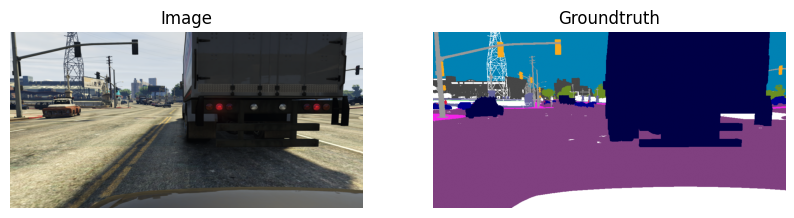

torch.Size([3, 512, 1024]) torch.Size([512, 1024])
img type: <class 'torch.Tensor'>  target: <class 'torch.Tensor'>
img: torch.Size([3, 512, 1024])  target: torch.Size([512, 1024])


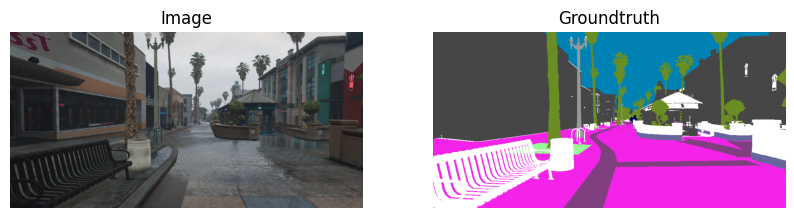

In [23]:
rows = 1
columns = 2
for i, (imgs, targets) in enumerate(train_dataloader):
    print(imgs[0].shape,targets[0].shape)

    figure = plt.figure(figsize=(10,20))
    figure.add_subplot(rows, columns,1)
    print("img type:",type(imgs[0]), " target:",type(targets[0]))
    print("img:", imgs[0].squeeze().shape, " target:",targets[0].squeeze().shape)
  

    plt.imshow(imgs[0].permute((1, 2, 0)))
    plt.axis('off')
    plt.title("Image")
    figure.add_subplot(rows, columns,2)
    
    plt.imshow(decode_segmap(targets[0]))
    plt.axis('off')
    plt.title("Groundtruth")
    plt.show()
    
    if i == 1: break

## Dataset creation

In [37]:
if FDA:
  #L 0.01, 0.05, 0.09
  # b == 0 --> 1x1, b == 1 --> 3x3, b == 2 --> 5x5, ...'
  SA = StyleAugment(n_images_per_style=MAX_SAMPLE_PER_CLIENT, L=0.01, size=(1024, 512), b=1) 

  clients = random.sample([_ for _ in range(TOT_CLIENTS)],N_STYLE)
  for c in clients:
    client_dataset = CityscapesClient(root=ROOT_DIR, uniform = UNIFORM, id_client = c, transform = transforms)
    # TODO: merge CityscapesClient with Cityscapes
    # client_dataset = Cityscapes(root=ROOT_DIR, transform=transforms, cl19 = cl19,filename=filename,  id_client = i)
    SA.add_style(client_dataset)

In [38]:
train_dataset = GTA5(root=ROOT_DIR_GTA5, transform=transforms)

if FDA:
  train_dataset.set_style_tf_fn(SA.apply_style)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
print("Dataset dimension: ", len(train_dataset))

Dataset dimension:  500


## GTA images with Cityscapes style visualization

torch.Size([3, 512, 1024]) torch.Size([512, 1024])
img type: <class 'torch.Tensor'>  target: <class 'torch.Tensor'>
img: torch.Size([3, 512, 1024])  target: torch.Size([512, 1024])


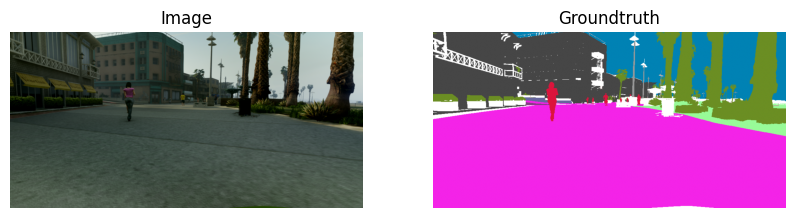

torch.Size([3, 512, 1024]) torch.Size([512, 1024])
img type: <class 'torch.Tensor'>  target: <class 'torch.Tensor'>
img: torch.Size([3, 512, 1024])  target: torch.Size([512, 1024])


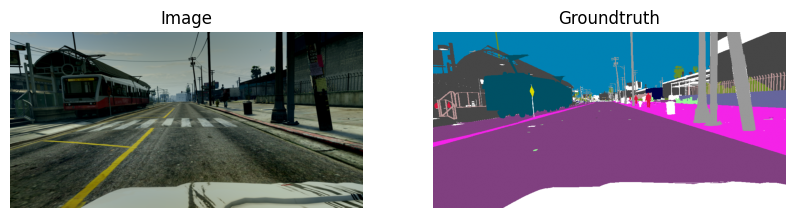

In [ ]:
n_images = 2
rows = 1
columns = 2
for i, (imgs, targets) in enumerate(train_dataloader):
    print(imgs[0].shape,targets[0].shape)

    figure = plt.figure(figsize=(10,20))
    figure.add_subplot(rows, columns,1)
    print("img type:",type(imgs[0]), " target:",type(targets[0]))
    print("img:", imgs[0].squeeze().shape, " target:",targets[0].squeeze().shape)

    plt.imshow(imgs[0].permute((1, 2, 0)))
    plt.axis('off')
    plt.title("Image")
    figure.add_subplot(rows, columns,2)
    
    plt.imshow(decode_segmap(targets[0]))
    plt.axis('off')
    plt.title("Groundtruth")
    plt.show()
    if i+1 == n_images: break

## Training

Validation Dataset

In [39]:
client_dataset = CityscapesClient(root=ROOT_DIR, uniform=True, id_client=0, transform=transforms)
val_dataloader = DataLoader(client_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

Checkpoint loading

In [40]:
if not os.path.isdir(CKPT_DIR):
  os.mkdir(CKPT_DIR)

if use_checkpoint and ckpt_path in os.listdir(CKPT_DIR):
  checkpoint = torch.load(os.path.join(CKPT_DIR,ckpt_path))
  print('Last checkpoint: Epoch {}, Loss {}, MIoU {}'.format(checkpoint['epoch'], checkpoint['loss'], checkpoint['miou']))

In [41]:
model = BiSeNetV2(NUM_CLASSES, output_aux=False, pretrained=True)
if use_checkpoint and ckpt_path in os.listdir(CKPT_DIR):
  model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss(ignore_index= 255) 

parameters_to_optimize = model.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
if use_checkpoint and ckpt_path in os.listdir(CKPT_DIR):
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [42]:
cudnn.benchmark # Calling this optimizes runtime

losses = []
losses_val = []
epochs = []

# wandb.watch(model, log='all')

if best_ckpt_path in os.listdir(CKPT_DIR):
    best_checkpoint = torch.load(os.path.join(CKPT_DIR,best_ckpt_path))
    best_loss = best_checkpoint['loss']
    best_miou = best_checkpoint['miou']


current_step = 0
start_epoch = 0
if use_checkpoint and ckpt_path in os.listdir(CKPT_DIR):
  start_epoch = checkpoint['epoch']

# Start iterating over the epochs
for epoch in range(start_epoch, NUM_EPOCHS):
  print('Starting epoch {}/{}'.format(epoch+1, NUM_EPOCHS))
  epochs.append(epoch+1)

  # Iterate over the dataset
  for images, labels in train_dataloader:

    images = images.to(DEVICE, dtype=torch.float32)
    labels = labels.to(DEVICE, dtype=torch.long)
    #print("images:",images.shape,"labels:",labels.shape)

    model.train()
    optimizer.zero_grad()

    predictions = model(images)
    #print("predictions:",predictions.shape,"labels:",labels.shape)
    loss = criterion(predictions, labels.squeeze())

    #wandb.log({"train/loss":loss})

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      miou = compute_moiu(model, val_dataloader)
      print('Step {}, Loss {}, MIoU {}'.format(current_step, loss.item(),miou))
      # wandb.log({"train/loss": loss})
    # Compute gradients for each layer and update weights
    loss.backward()
    optimizer.step()

    current_step += 1

  # save intermediate checkpoint
  torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(), 'loss': loss, 'miou': miou}, 
             os.path.join(CKPT_DIR,ckpt_path))
  
  # save/update best checkpoint
  if best_ckpt_path not in os.listdir(CKPT_DIR) or (best_ckpt_path in os.listdir(CKPT_DIR) and best_miou < miou):
    torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(), 'loss': loss, 'miou': miou}, 
               os.path.join(CKPT_DIR,best_ckpt_path))
    best_loss = loss
    best_miou = miou

Starting epoch 1/10
Step 0, Loss 3.379983425140381, MIoU 0.01372423768043518
Step 20, Loss 1.1634621620178223, MIoU 0.07042951881885529
Step 40, Loss 0.7596096992492676, MIoU 0.11211415380239487
Step 60, Loss 0.6479418277740479, MIoU 0.11218385398387909
Starting epoch 2/10
Step 80, Loss 0.5433042049407959, MIoU 0.12472023814916611
Step 100, Loss 0.7161750793457031, MIoU 0.12820804119110107
Step 120, Loss 0.48596903681755066, MIoU 0.1430027186870575
Starting epoch 3/10


KeyboardInterrupt: ignored

## Validation

In [44]:
if best_ckpt_path in os.listdir(CKPT_DIR):
  best_checkpoint = torch.load(os.path.join(CKPT_DIR,best_ckpt_path))
  model = BiSeNetV2(NUM_CLASSES, output_aux=False, pretrained=True)
  model.load_state_dict(best_checkpoint['model_state_dict'])
  # Set dropout and batch normalization layers to evaluation mode before running inference.
  model.eval() 
  print('Model correctly loaded')
else: 
  print('There is no model to load')

Model correctly loaded


Load Validation Dataset

In [45]:
id_client = random.randint(0,TOT_CLIENTS-1)
val_dataset = CityscapesClient(root=ROOT_DIR, uniform=True, id_client=id_client, transform=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
print("Dataset dimension: ", len(val_dataset))

Dataset dimension:  20


torch.Size([3, 512, 1024]) torch.Size([512, 1024])
img: torch.Size([3, 512, 1024])  target: torch.Size([512, 1024])
pred: torch.Size([8, 512, 1024])


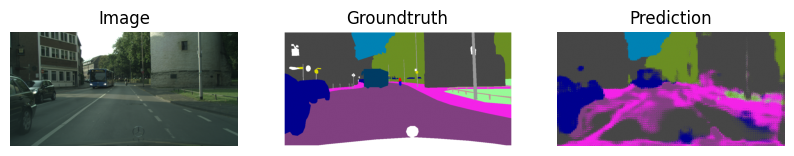

torch.Size([3, 512, 1024]) torch.Size([512, 1024])
img: torch.Size([3, 512, 1024])  target: torch.Size([512, 1024])
pred: torch.Size([8, 512, 1024])


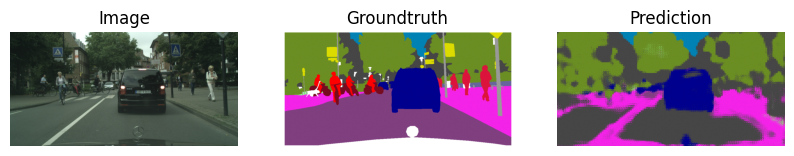

Validation MIoU: 0.15055574476718903


In [46]:
validation_plot(net= model, val_dataloader=val_dataloader, n_image=20)
torch.cuda.empty_cache()
miou = compute_moiu(net=model, val_dataloader=val_dataloader)
print('Validation MIoU: {}'.format(miou))